## Instance segmentation tutorial


Detectools aims to provide to generalize trainning and inference processes for detection & instance segmentation models. As each model has it's specific data format and data structure it can be time consumming to try one model then another etc. To tackle this issue detectools define a common data structure (Data stored on computer) and python data format (data on python classes) for all models in library. Moreover detectools provides trainning and inference pipelines to develop and deploy models.

### Data structure

To use detectools data should be stored with the following structure:

    . Dataset Name
            ├── images
                ├── name01.png
                ├── name02.png
                └── ...
            └── coco_annotations.json

File "coco_annotations.json" contain detection annotations in [COCO format](https://cocodataset.org/#format-data). This structure is compatible with the DetectionDataset class which is a torch.Dataset and support batchification with Dataloaders.

### 0. Setup envrionnement for tutorial

In the following cell you should set up the environnement for the tutorial. You should provide the device you want to work on (CPU or GPU), the path to a dataset (with the structure above), the path to a folder for outputs of the tutorial and the number of classes on your dataset.

This tutorial will focus on instance_segmentation task. If you want to only use detection mode of detectools you can go to "overall_detection.ipynb" tutorial.

Note that detectools mode has "detection" as default value and to use "instance_segmentation" mode you should as first line in your script call the set_lib_mode with "instance_segmentation" as value.

In [2]:
from pathlib import Path
import shutil
from detectools import set_lib_mode

# switch to instance segmentation mode
set_lib_mode("instance_segmentation")

dataset_path = "../../../../data/dev/maize" # path to prepared dataset
output_path = "../../../detection_tutorial_output" # where to store outputs
num_classes = 1 # number of classes in your dataset
batch_size = 2 # Size of batch depending on your ressources
device = "cuda" # "cuda" for GPU

# remove existing output_folder if already exists
if Path(output_path).exists():
    shutil.rmtree(output_path)

### 1. Data preparation

Some functions are provided in detectools.utils.data_mangement.py to manage your data (splitting dataset, merging jsons, ...). This functions works on the data structure on storage. Here we will split randomly the dataset in 3 subsets for train, valid and test.

In [3]:
from detectools.data_management import split_dataset

split = (0.6, 0.2, 0.2) # train, valid, test proprotions
splitted_dataset_path = f"{output_path}/split_data"
split_dataset(dataset_path, splitted_dataset_path, proportions=split)

Splitting dataset: ../../../../data/dev/maize
Export train data:


Exporting:   0%|          | 0/6 [00:00<?, ?it/s]

Exporting: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


Export valid data:


Exporting: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Export test data:


Exporting: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


### 2. Data format

Detectools define a common detection data format (boxes, labels) for all operations in library. This format supports many transformations (such as NMS, padding, cropping or even slicing). Annotations and predictions are stored in this format.

* spatial_size: (H, W), shape of corresponding image.
* labels: (N,) values of objects classes.
* boxes : Shape (N, 4) for N objects and 4 values of boxes (can be in different format according to box_format, default is coco XYWH).
* masks: Stacked mask of shape (H, W) with values from 0 (background) to N objects.
* scores (optionnal): Scores are confidence of predictions of shape (N,)
* box_format: The boxes format ("XYWH", "CXCYWH", "XYXY"). Default to "XYWH".

In this format, one object is defined by all values of labels, boxes and other tensors of shape (N, ...) at the same index. For example, object 3 is the combinations of labels[2], boxes[2]. The "masks" value is special because masks are stores as a stacked masks to limit memory usage. During SegmentationFormat construction masks should be passed as stacked mask (Tensor) or as DetectMask (custom class for masks in detectools). This class will manage some specific transformations for masks (.i.e masks __getitem__ etc..). You can construct a mask from binary masks using the DetecMask.from_binary_masks() method that will return DetectMask. Note that this is lower level utilisation of library and it's not needed to train and use segmentation models.

Let's create a dummy format:

In [4]:
import torch
from detectools.formats import Format

spatial_size = (1024, 1024) # H, W of dummy image
boxes = torch.tensor([[50,120,140,130], [500,260,80,120], [5,10,200,250]]) # shape (N, 4), N objects and x, y, width, height (x,y top left corner point)
labels = torch.tensor([0,1,1]) # shape N for N objects. Values are classes values.
masks = torch.randint(4,(1024,1024)) # shape (H, W) with objects in classes 0 - 3.
target = Format(spatial_size, labels, boxes, masks)

print(type(target))
print(target.size, target.spatial_size)


<class 'detectools.formats.segmentation_format.SegmentationFormat'>
3 (1024, 1024)


You can see that the class of target is "SegmentationFormat".

Data can be accessed with the method **get** and can be passed with the function **set** after Format construction. It is also possible to pass other values to formats as long as they are either tensors with shape (N, ...) or Sequence. All values are stored in data dict in Format. For more information you can see the formats modules in library. Be aware that if you need to access mask data directly from SegmentationFormat you will get DetectMask. Data as tensor with shape H, W can be accessed with ._mask attribute.

In [5]:
target.set("labels", torch.tensor([3,4,3])) # change labels
boxes, labels = target.get("boxes", "labels")
print(boxes, labels)

# adding new informations on object size: 0 for small, 1 for large
object_size = torch.tensor([0,1,0])
target.set("object_sizes", object_size)

mask = target.get("masks")
print(mask._mask.shape, torch.unique(mask._mask))
# print number of objects
print(target.size)
# display data dict
print(target.data)

BoundingBoxes([[ 50, 120, 140, 130],
               [500, 260,  80, 120],
               [  5,  10, 200, 250]], dtype=torch.int32, format=BoundingBoxFormat.XYWH, canvas_size=(1024, 1024)) tensor([3, 4, 3])
torch.Size([1024, 1024]) tensor([0, 1, 2, 3], dtype=torch.int32)
3
{'boxes': BoundingBoxes([[ 50, 120, 140, 130],
               [500, 260,  80, 120],
               [  5,  10, 200, 250]], dtype=torch.int32, format=BoundingBoxFormat.XYWH, canvas_size=(1024, 1024)), 'labels': tensor([3, 4, 3]), 'masks': <detectools.formats.detect_mask.DetectMask object at 0x70bec537ae90>, 'object_sizes': tensor([0, 1, 0])}


Slicing the Format return another Format with a subset of objects. Individual objects can also be gathered true the get_object() method. It returns an instance of Annotation class. This class store data of the object and allow to export data in COCO format (dict of COCO key values for 1 annotation).

In [6]:
subset_format = target[[0,2]]
wanted_object = target.get_object(1)
coco_like_data = wanted_object.object_to_coco()

print(target.size, subset_format.size)
print(type(wanted_object), wanted_object.boxe)
print(coco_like_data)


3 2
<class 'detectools.formats.segmentation_format.SegmentationAnnotation'> tensor([500, 260,  80, 120], dtype=torch.int32)
{'id': 1, 'bbox': [500, 260, 80, 120], 'segmentation': [[1011, 1023, 1012, 1023], [1004, 1023], [997, 1023], [994, 1023], [989, 1023], [987, 1023], [959, 1023], [947, 1023], [943, 1023], [934, 1023], [925, 1023], [922, 1023], [920, 1023], [900, 1023, 901, 1023], [888, 1023], [883, 1023, 884, 1023], [880, 1023], [871, 1023, 872, 1023], [868, 1023], [863, 1023], [852, 1023, 855, 1023], [850, 1023], [828, 1023], [822, 1023], [811, 1023], [808, 1023], [786, 1023], [770, 1023, 772, 1023], [761, 1023], [742, 1023], [728, 1023], [705, 1023], [681, 1023, 682, 1023], [667, 1023], [657, 1023], [649, 1023], [634, 1023], [631, 1023, 632, 1023], [626, 1023], [623, 1023], [579, 1023], [563, 1023, 566, 1023], [533, 1023], [528, 1023], [524, 1023], [514, 1023], [511, 1023], [484, 1023, 485, 1023], [465, 1023], [460, 1023], [446, 1023], [419, 1023, 420, 1023], [416, 1023], [385, 1

### 3. DetectionDataset & DetectionLoader

Detectools provide a specific dataset to access data directly from data structure. This dataset supports preprocessing (default to imagenet preprocessing) & augmentation (default to None). Getitem of dataset return image as tensor and corresponding annotation as Format. You can pass few arguments to process some transformations within the dataset:

* augmentation
* preprocessing
* convert_labels_dict (to dynamically convert labels with a dict of conversion)
* min_border_size (minimum border size of boxes to consider object as true object, remove all objects with border smaller than this value)

In [7]:
from detectools.data import DetectionDataset

dataset = DetectionDataset(dataset_path)

image, target, name = dataset[0]
print(image.shape, target.size)

torch.Size([3, 1024, 1024]) 16


With the DetectionDataset you can also gather data from a specific image by providing the name of image with the following method:

In [8]:
image, target = dataset.get_image_data(name)

This dataset can be wrapped in a DetectionLoader thant process specific collate for targets (format). It returns images with shape (N, 3, H, W) with N the batch size and a BatchedFormat that contains Format for all images in a dict.

In [9]:
from detectools.data import DetectionLoader

loader = DetectionLoader(dataset, batch_size=batch_size)
for i, (batch_images, batch_targets, names) in enumerate(loader):
    # get size of each format in batch_targets
    sizes = [f.size for f in batch_targets.formats.values()]
    print(batch_images.shape, sizes)
    print(names)
    # break after 10 iterations
    if i >= 10:
        break

torch.Size([2, 3, 1024, 1024]) [16, 20]
{0: 'plot_23ZS34_Y16X005_DJI_20230530145203_0552_crop1_(1050, 778)_(2074, 1802).png', 1: 'plot_23ZS34_Y16X009_DJI_20230530144628_0300_crop1_(987, 521)_(2011, 1545).png'}


torch.Size([2, 3, 1024, 1024]) [20, 21]
{0: 'plot_23ZS34_Y17X010_DJI_20230530144413_0199_crop1_(1095, 1565)_(2119, 2589).png', 1: 'plot_23ZS34_Y17X004_DJI_20230530145831_0682_crop1_(1052, 790)_(2076, 1814).png'}
torch.Size([2, 3, 1024, 1024]) [23, 18]
{0: 'plot_23ZS34_Y16X003_DJI_20230530145903_0707_crop1_(1155, 1924)_(2179, 2948).png', 1: 'plot_23ZS34_Y15X009_DJI_20230530144622_0296_crop1_(993, 432)_(2017, 1456).png'}
torch.Size([2, 3, 1024, 1024]) [20, 18]
{0: 'plot_23ZS34_Y17X009_DJI_20230530144633_0304_crop1_(979, 1669)_(2003, 2693).png', 1: 'plot_23ZS34_Y15X005_DJI_20230530145158_0548_crop1_(1063, 1823)_(2087, 2847).png'}
torch.Size([2, 3, 1024, 1024]) [18, 23]
{0: 'plot_23ZS34_Y15X004_DJI_20230530145820_0674_crop1_(1055, 191)_(2079, 1215).png', 1: 'plot_23ZS34_Y16X002_DJI_20230530150112_0804_crop1_(1037, 1097)_(2061, 2121).png'}


DetectionLoader supports batchification with images with different shapes. It always pad all images to fit the maximum height & widdth of the batch. 

### 4. Augmentation

Detectools provide an augmentation class that can apply every transformations of torchvisions.transforms.v2 to images and boxes. This class takes list of transforms where parameters have been set.

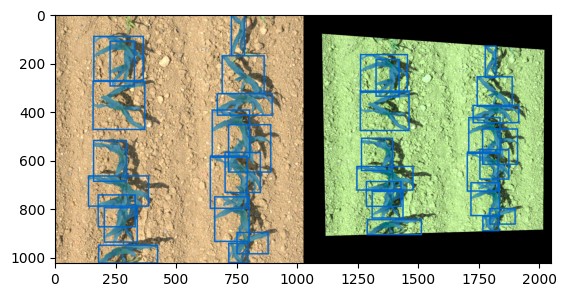

In [20]:
import torchvision.transforms.v2 as T
from computervisiontools.preprocessing import build_preprocessing
from computervisiontools import to_numpy
from detectools.visualisation import visualisation
from detectools.data.augmentation import Augmentation
import matplotlib.pyplot as plt

# create augmentation
transforms = [
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(hue=0.2, brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomPerspective(p=0.5, distortion_scale=0.3)
]
augment = Augmentation(transforms)
# shut down preprocessing to gather image in uint8
dataset.preprocessing = None
image, target, name = dataset[1]
augmented_image, augmened_target = augment(image, target)
# create visualisation
raw_visualisation = visualisation(image, target)
augmented_visualisation = visualisation(augmented_image, augmened_target)
concat = torch.cat([raw_visualisation, augmented_visualisation], dim=2)
# display augmentation
plt.imshow(to_numpy(concat))

# Put back the preprocessing for follwing steps
dataset.preprocessing = build_preprocessing()

### 5. Trainning

Detectools provide a Trainer class that wrap process of trainning (train epoch, valid epoch, metric computation, tensorboard writing). Let's define a better environnement for trainning by create train dataset and valid dataset. We will reuse the splitting we did on our dataset in step 1 and pass augmentation to train.

In [11]:
train_set = DetectionDataset(f"{output_path}/split_data/train", augmentation=augment)
valid_set = DetectionDataset(f"{output_path}/split_data/valid")

train_loader = DetectionLoader(train_set, batch_size=batch_size)
valid_loader = DetectionLoader(valid_set, batch_size=batch_size)

#### 5.1 Model

Models provided by the library are in detectools.models. Each model inheriths from BaseModel and have the same methods but they have also specific methods to convert data formats from detectools to their formats and vice versa. Those functions don't need to be called by user directly. Some common attributes can be passed on model creation, for instance the three parameters of instances selection for prediction (max_detections, confidence_thresold, nms_threshold).

* confidence_thr: Threshold on confidence score. Only objects with confidence higher than this threshold will be kept. (Default 0.5).
* nms_threshold: Box IoU threshold to consider objects as overlapping during Non Max suppression algortihm. (Default 0.45).
* max_detections: Keep at max N objects with higer scores (N == max_detections). (Default to 100).

New models can be added to the library as long as they respect methods from abstract class BaseModel.

Let's use a Yolov8 model.

Models can bes used directly with the native forward method, but you can use also detectools BaseModel method to get post_processed outputs as Format or compute directly loss. If you wish to work at a lower level it's necessary to learn about the functionnement of the parent class of the model. For example YoloDetection model inherits from BaseModel from detectools but also from DetectionModel from Ultralytics.

In [12]:
from detectools.models import Yolov8Segmentation

model = Yolov8Segmentation(num_classes=1)
model.eval()
# raw model utilisation
raw_outputs = model(batch_images)
print(type(raw_outputs))
# detectools prediction
prediction = model.get_predictions(batch_images)
print(prediction)
# compute loss
loss, predictions = model.run_forward(batch_images, batch_targets, predict=True)
print(loss)

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

<class 'tuple'>
{'loss': tensor(26.9782, grad_fn=<MulBackward0>), 'loss_box': tensor(2.5228), 'loss_seg': tensor(5.0183), 'loss_cls': tensor(3.2572), 'loss_dfl': tensor(2.6909)}


#### 5.2 Metrics

Detectools provides some metrics for detection and instance segmentation. As detection is a composition of 2 task: detect an object and classify it, there is 2 types of metrics (DetectionMetrics and ClassificationMetrics). DetectionMetrics does not evaluate classification and vice versa. A good model is a model that obtain good performances in both detection and classification tasks. Those metrics inherith from Torchmetrics and works with the three methods update(), compute() and reset(). They accumulate and average performance accross samples and return values with all averaging methods:

* global/samplewise: to average over images or over objects in dataset (Detection & Classification).
* Micro/Macro: To average the mean/class (class proportions are erased) or mean over objects (proportions is kept).

See detectools.metrics & [torchmetrics documentation](https://lightning.ai/docs/torchmetrics/stable/) for more details.

When we train models for instance segmentation we can be interested by quality of semantic segmentation so detectools provide specific metrics for instance segmentation (SemanticSegmentationMetric). This will only consider object class for pixels in masks.

In [13]:
from detectools.metrics import DetectF1score, ClassifF1score, SemanticF1score

detectf1 = DetectF1score()
classificationf1 = ClassifF1score(num_classes=num_classes)
semanticf1 = SemanticF1score(num_classes=num_classes)

detect = detectf1(target, augmened_target)
classif = classificationf1(target, augmened_target)

print(detect, classif, semanticf1)

detectf1.reset()
classificationf1.reset()
semanticf1.reset()

{'global': tensor(0.), 'samplewise': tensor(0.)} {'_global': tensor(nan), '_samplewise': tensor(nan)} SemanticF1score(
  (stat_score): BinaryStatScores()
)


#### 5.3 Trainer & loops

Trainer objects wrap all trainning objects:

* Model
* Optimizer
* Metrics

Instance selection parameters (confidence_thr, nms_thr) defined in Trainer override the ones created in model, they can be passed as arguments of Trainer constructor.

A directory path to store tensorboard logs can also be passed to Trainer.

In [14]:
from torch.optim import Adam
from detectools.train import Trainer

optimizer = Adam(model.parameters(), lr=1e-4)
metrics = [detectf1, classificationf1, semanticf1]
trainer = Trainer(model, optimizer, log_dir=f"{output_path}/tensorboard_logs", metrics=metrics, device=device)

Let's train for a few epochs with train_epoch() and valid_epoch() methods:

In [15]:
for epoch in range(5): # change number of epochs according to your dataset
    trainer.train_epoch(train_loader, epoch)
    trainer.valid_epoch(valid_loader, epoch)
    print('\n')

Epoch 0/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, loss : 11.275 loss_box : 1.115 loss_seg : 1.765 loss_cls : 1.535 loss_dfl : 1.223 DetectF1score : 0.0 ClassifF1score : nan SemanticF1score : 0.0 ]


Epoch 1/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s, loss : 11.02 loss_box : 1.123 loss_seg : 1.665 loss_cls : 1.522 loss_dfl : 1.199 DetectF1score : 0.0 ClassifF1score : nan SemanticF1score : 0.0 ]


Epoch 2/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss : 11.106 loss_box : 1.17 loss_seg : 1.691 loss_cls : 1.507 loss_dfl : 1.185 DetectF1score : 0.0 ClassifF1score : nan SemanticF1score : 0.0 ]


Epoch 3/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, loss : 10.378 loss_box : 1.091 loss_seg : 1.623 loss_cls : 1.417 loss_dfl : 1.059 DetectF1score : 0.0 ClassifF1score : nan SemanticF1score : 0.0 ]


Epoch 4/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, loss : 9.944 loss_box : 1.064 loss_seg : 1.541 loss_cls : 1.356 loss_dfl : 1.011 DetectF1score : 0.0 ClassifF1score : nan SemanticF1score : 0.0 ]

You can interact with trainer attributes during trainning and gather losss values for each epoch. For example you can add a learning rate decay, add the learning rate value to tensorboard and manage to save only models that reach best loss value in valid:

In [16]:
from torch.optim.lr_scheduler import ExponentialLR

lr_scheduler = ExponentialLR(trainer.optimizer, gamma=0.99)
best_loss = None

for epoch in range(20): # change number of epochs according to your dataset
    trainer.train_epoch(train_loader, epoch)
    # gather valid loss
    valid_loss = trainer.valid_epoch(valid_loader, epoch)
    # add lr to board & decrease lr
    trainer.board.add_scalar("lr", lr_scheduler.get_last_lr()[0], epoch)
    lr_scheduler.step()
    # save model if best model
    if best_loss==None:
        best_loss = valid_loss["loss"]

    if valid_loss["loss"].item() < best_loss:
        torch.save(trainer.model, f"{output_path}/best.pth")
        best_loss = valid_loss["loss"]
    print('\n')

Epoch 0/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, loss : 9.601 loss_box : 1.044 loss_seg : 1.473 loss_cls : 1.304 loss_dfl : 0.98 DetectF1score : 0.0 ClassifF1score : nan SemanticF1score : 0.0 ]


Epoch 1/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, loss : 9.355 loss_box : 1.015 loss_seg : 1.451 loss_cls : 1.257 loss_dfl : 0.954 DetectF1score : 0.0 ClassifF1score : nan SemanticF1score : 0.0 ]


Epoch 2/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss : 9.08 loss_box : 0.984 loss_seg : 1.425 loss_cls : 1.211 loss_dfl : 0.92 DetectF1score : 0.0 ClassifF1score : nan SemanticF1score : 0.0 ]


Epoch 3/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s, loss : 8.851 loss_box : 0.97 loss_seg : 1.361 loss_cls : 1.183 loss_dfl : 0.912 DetectF1score : 0.0 ClassifF1score : nan SemanticF1score : 0.0 ]


Epoch 4/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s, loss : 8.659 loss_box : 0.979 loss_seg : 1.299 loss_cls : 1.144 loss_dfl : 0.907 DetectF1score : 0.0 ClassifF1score : nan SemanticF1score : 0.0 ]


Epoch 5/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s, loss : 8.41 loss_box : 0.966 loss_seg : 1.25 loss_cls : 1.099 loss_dfl : 0.89 DetectF1score : 0.0 ClassifF1score : nan SemanticF1score : 0.0 ]


Epoch 6/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s, loss : 8.291 loss_box : 0.957 loss_seg : 1.22 loss_cls : 1.081 loss_dfl : 0.887 DetectF1score : 0.0 ClassifF1score : nan SemanticF1score : 0.0 ]


Epoch 7/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s, loss : 8.194 loss_box : 0.933 loss_seg : 1.195 loss_cls : 1.073 loss_dfl : 0.895 DetectF1score : 0.0 ClassifF1score : nan SemanticF1score : 0.0 ]


Epoch 8/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s, loss : 8.092 loss_box : 0.935 loss_seg : 1.189 loss_cls : 1.035 loss_dfl : 0.887 DetectF1score : 0.0 ClassifF1score : nan SemanticF1score : 0.0 ]


Epoch 9/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss : 8.007 loss_box : 0.928 loss_seg : 1.202 loss_cls : 0.997 loss_dfl : 0.877 DetectF1score : 0.048 ClassifF1score : 1.0 SemanticF1score : 0.053 ]


Epoch 10/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s, loss : 8.021 loss_box : 0.927 loss_seg : 1.226 loss_cls : 0.972 loss_dfl : 0.885 DetectF1score : 0.093 ClassifF1score : 1.0 SemanticF1score : 0.071 ]


Epoch 11/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, loss : 7.977 loss_box : 0.917 loss_seg : 1.222 loss_cls : 0.965 loss_dfl : 0.885 DetectF1score : 0.14 ClassifF1score : 1.0 SemanticF1score : 0.127 ]


Epoch 12/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, loss : 7.922 loss_box : 0.921 loss_seg : 1.207 loss_cls : 0.957 loss_dfl : 0.876 DetectF1score : 0.095 ClassifF1score : 1.0 SemanticF1score : 0.112 ]


Epoch 13/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, loss : 7.856 loss_box : 0.922 loss_seg : 1.181 loss_cls : 0.955 loss_dfl : 0.87 DetectF1score : 0.14 ClassifF1score : 1.0 SemanticF1score : 0.14 ]


Epoch 14/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, loss : 7.795 loss_box : 0.917 loss_seg : 1.168 loss_cls : 0.945 loss_dfl : 0.868 DetectF1score : 0.182 ClassifF1score : 1.0 SemanticF1score : 0.146 ]


Epoch 15/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, loss : 7.741 loss_box : 0.921 loss_seg : 1.176 loss_cls : 0.918 loss_dfl : 0.856 DetectF1score : 0.222 ClassifF1score : 1.0 SemanticF1score : 0.165 ]


Epoch 16/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, loss : 7.684 loss_box : 0.924 loss_seg : 1.185 loss_cls : 0.89 loss_dfl : 0.843 DetectF1score : 0.333 ClassifF1score : 1.0 SemanticF1score : 0.267 ]


Epoch 17/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, loss : 7.728 loss_box : 0.93 loss_seg : 1.176 loss_cls : 0.895 loss_dfl : 0.863 DetectF1score : 0.333 ClassifF1score : 1.0 SemanticF1score : 0.29 ]


Epoch 18/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, loss : 7.707 loss_box : 0.929 loss_seg : 1.161 loss_cls : 0.889 loss_dfl : 0.874 DetectF1score : 0.333 ClassifF1score : 1.0 SemanticF1score : 0.314 ]


Epoch 19/Valid: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, loss : 7.695 loss_box : 0.938 loss_seg : 1.151 loss_cls : 0.872 loss_dfl : 0.886 DetectF1score : 0.367 ClassifF1score : 1.0 SemanticF1score : 0.345 ]

### Inference

Detectools provide a wrapper class to run inference: Predictor. This class will manage the forward pass on image, the visualisation and the export in json formats. As images to predict can be much more larger than patch used for trainning, Detectools provide an algorithm to patchify the inference. Large images will be cut in smaller patches, with optionnaly an overlap between these patchs. Each patch is predicted than merged together. To remove remove dummy predictions caused by merging (objects at frontiers of multiple patchs) Predictor will apply  a NMS algotithm after merging. If not patch size is provided when Predictor construction, the default patch_size will be size of image.

Once again the three parameters of instance predictions can be defined in the Predictor construction:

* confidence_thr
* nms_thr
* max detections

Let's do some predictions with our model. Be aware that if the dataset you provide is very large or ith the task is complex you may not see any results in the following case. To insure to have some results you can work on very small dataset or try to overfit and predict on trainning set.

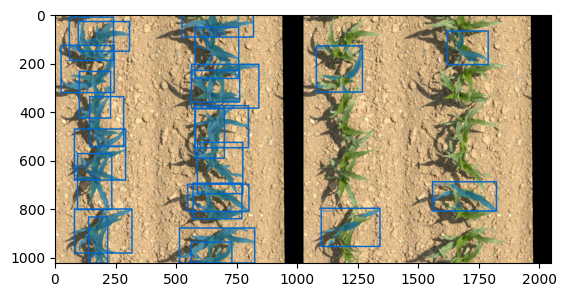

In [17]:
from detectools.inference import Predictor

model = torch.load(f"{output_path}/best.pth")
dataset = DetectionDataset(f"{output_path}/split_data/test", preprocessing=None)
image, target, name = dataset[0]

predictor = Predictor(model, device=device)
predictions = predictor.predict(image, visualisation_path=f"{output_path}/test_visualisation.png")

target_visualisation = visualisation(image, target)
prediction_visualisation = visualisation(image, predictions, classes=dataset.classes)
concat = torch.cat([target_visualisation, prediction_visualisation], dim=2)

plt.imshow(to_numpy(concat))